# VARLiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.16.2', '0.24.2', '0.11.1', '1.5.2']


## Test data
We create test data consisting of 5 variables.

In [2]:
B0 = [
    [0,-0.12,0,0,0],
    [0,0,0,0,0],
    [-0.41,0.01,0,-0.02,0],
    [0.04,-0.22,0,0,0],
    [0.15,0,-0.03,0,0],
]
B1 = [
    [-0.32,0,0.12,0.32,0],
    [0,-0.35,-0.1,-0.46,0.4],
    [0,0,0.37,0,0.46],
    [-0.38,-0.1,-0.24,0,-0.13],
    [0,0,0,0,0],
]
causal_order = [1, 0, 3, 2, 4]

# data generated from B0 and B1
X = pd.read_csv('data/sample_data_var_lingam.csv')

## Causal Discovery
To run causal discovery, we create a `VARLiNGAM` object and call the `fit` method.

In [3]:
model = lingam.VARLiNGAM()
model.fit(X)

Using the `causal_order_` properties, we can see the causal ordering as a result of the causal discovery.

In [4]:
model.causal_order_

[1, 0, 3, 2, 4]

Also, using the `adjacency_matrices_` properties, we can see the adjacency matrix as a result of the causal discovery.

In [5]:
# B0
model.adjacency_matrices_[0]

array([[ 0.   , -0.144,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.372,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.069, -0.21 ,  0.   ,  0.   ,  0.   ],
       [ 0.083,  0.   , -0.033,  0.   ,  0.   ]])

In [6]:
# B1
model.adjacency_matrices_[1]

array([[-0.366, -0.011,  0.074,  0.297,  0.025],
       [-0.083, -0.349, -0.168, -0.327,  0.43 ],
       [ 0.077, -0.043,  0.427,  0.046,  0.49 ],
       [-0.389, -0.097, -0.263,  0.014, -0.159],
       [-0.018,  0.01 ,  0.001,  0.071,  0.003]])

In [7]:
model.residuals_

array([[-0.308,  0.911, -1.152, -1.159,  0.179],
       [ 1.364,  1.713, -1.389, -0.265, -0.192],
       [-0.861,  0.249,  0.479, -1.557, -0.462],
       ...,
       [-1.202,  1.819,  0.99 , -0.855, -0.127],
       [-0.133,  1.23 , -0.445, -0.753,  1.096],
       [-0.069,  0.558,  0.21 , -0.863, -0.189]])

Using `DirectLiNGAM` for the `residuals_` properties, we can calculate B0 matrix.

In [8]:
dlingam = lingam.DirectLiNGAM()
dlingam.fit(model.residuals_)
dlingam.adjacency_matrix_

array([[ 0.   , -0.144,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.372,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.069, -0.21 ,  0.   ,  0.   ,  0.   ],
       [ 0.083,  0.   , -0.033,  0.   ,  0.   ]])

We can draw a causal graph by utility funciton.

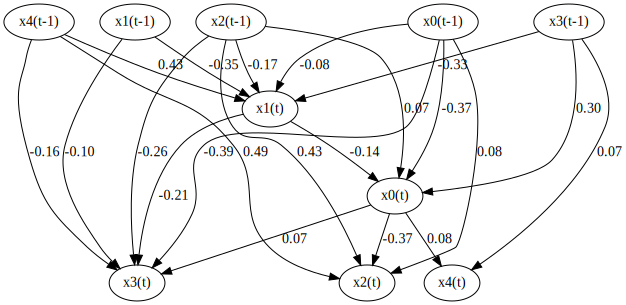

In [9]:
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
make_dot(np.hstack(model.adjacency_matrices_), ignore_shape=True, lower_limit=0.05, labels=labels)

## Independence between error variables
To check if the LiNGAM assumption is broken, we can get p-values of independence between error variables. The value in the i-th row and j-th column of the obtained matrix shows the p-value of the independence of the error variables $e_i$ and $e_j$.

In [10]:
p_values = model.get_error_independence_p_values()
print(p_values)

[[0.    0.065 0.068 0.038 0.249]
 [0.065 0.    0.13  0.88  0.57 ]
 [0.068 0.13  0.    0.321 0.231]
 [0.038 0.88  0.321 0.    0.839]
 [0.249 0.57  0.231 0.839 0.   ]]


## Bootstrap

### Bootstrapping
We call `bootstrap()` method instead of `fit()`. Here, the second argument specifies the number of bootstrap sampling.

In [11]:
model = lingam.VARLiNGAM()
result = model.bootstrap(X, n_sampling=100)

## Causal Directions
Since `BootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.3 or more.

In [12]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.3, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [13]:
print_causal_directions(cdc, 100, labels=labels)

x0(t) <--- x0(t-1) (b<0) (100.0%)
x1(t) <--- x1(t-1) (b<0) (100.0%)
x1(t) <--- x3(t-1) (b<0) (100.0%)
x1(t) <--- x4(t-1) (b>0) (100.0%)
x2(t) <--- x2(t-1) (b>0) (100.0%)
x2(t) <--- x4(t-1) (b>0) (100.0%)
x3(t) <--- x0(t-1) (b<0) (100.0%)
x2(t) <--- x0(t) (b<0) (99.0%)


## Directed Acyclic Graphs
Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.2 or more.

In [14]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.2, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [15]:
print_dagc(dagc, 100, labels=labels)

DAG[0]: 57.0%
	x0(t) <--- x0(t-1) (b<0)
	x0(t) <--- x3(t-1) (b>0)
	x1(t) <--- x1(t-1) (b<0)
	x1(t) <--- x3(t-1) (b<0)
	x1(t) <--- x4(t-1) (b>0)
	x2(t) <--- x0(t) (b<0)
	x2(t) <--- x2(t-1) (b>0)
	x2(t) <--- x4(t-1) (b>0)
	x3(t) <--- x1(t) (b<0)
	x3(t) <--- x0(t-1) (b<0)
	x3(t) <--- x2(t-1) (b<0)
DAG[1]: 42.0%
	x0(t) <--- x0(t-1) (b<0)
	x0(t) <--- x3(t-1) (b>0)
	x1(t) <--- x1(t-1) (b<0)
	x1(t) <--- x3(t-1) (b<0)
	x1(t) <--- x4(t-1) (b>0)
	x2(t) <--- x0(t) (b<0)
	x2(t) <--- x2(t-1) (b>0)
	x2(t) <--- x4(t-1) (b>0)
	x3(t) <--- x0(t-1) (b<0)
	x3(t) <--- x2(t-1) (b<0)
DAG[2]: 1.0%
	x0(t) <--- x0(t-1) (b<0)
	x0(t) <--- x3(t-1) (b>0)
	x1(t) <--- x1(t-1) (b<0)
	x1(t) <--- x3(t-1) (b<0)
	x1(t) <--- x4(t-1) (b>0)
	x2(t) <--- x0(t) (b<0)
	x2(t) <--- x2(t-1) (b>0)
	x2(t) <--- x4(t-1) (b>0)
	x3(t) <--- x1(t) (b<0)
	x3(t) <--- x0(t-1) (b<0)
	x3(t) <--- x2(t-1) (b<0)
	x4(t) <--- x0(t) (b>0)


## Probability
Using the `get_probabilities()` method, we can get the probability of bootstrapping.

In [16]:
prob = result.get_probabilities(min_causal_effect=0.1)
print('Probability of B0:\n', prob[0])
print('Probability of B1:\n', prob[1])

Probability of B0:
 [[0.   0.98 0.   0.02 0.  ]
 [0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.01]
 [0.1  1.   0.   0.   0.  ]
 [0.51 0.   0.02 0.08 0.  ]]
Probability of B1:
 [[1.   0.   0.02 1.   0.  ]
 [0.   1.   1.   1.   1.  ]
 [0.03 0.   1.   0.05 1.  ]
 [1.   0.16 1.   0.   1.  ]
 [0.   0.   0.   0.25 0.  ]]


## Total Causal Effects
Using the `get_causal_effects()` method, we can get the list of total causal effect. The total causal effects we can get are dictionary type variable.
We can display the list nicely by assigning it to pandas.DataFrame. Also, we have replaced the variable index with a label below.

In [17]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)
df = pd.DataFrame(causal_effects)

df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,x1(t),x0(t),-0.131094,1.00
1,x4(t-1),x2(t),0.463646,1.00
2,x4(t-1),x3(t),-0.224349,1.00
3,x0(t-1),x0(t),-0.297905,1.00
4,x1(t),x3(t),-0.217983,1.00
5,x3(t-1),x0(t),0.273013,1.00
6,x2(t-1),x3(t),-0.177952,1.00
7,x0(t-1),x3(t),-0.269388,1.00
8,x1(t-1),x1(t),-0.260914,1.00
9,x2(t-1),x2(t),0.310371,1.00


We can easily perform sorting operations with pandas.DataFrame.

In [18]:
df.sort_values('effect', ascending=False).head()

,from,to,effect,probability
1,x4(t-1),x2(t),0.463646,1.00
10,x4(t-1),x1(t),0.397907,1.00
9,x2(t-1),x2(t),0.310371,1.00
5,x3(t-1),x0(t),0.273013,1.00
16,x0(t),x4(t),0.106232,0.86


And with pandas.DataFrame, we can easily filter by keywords. The following code extracts the causal direction towards x1(t).

In [19]:
df[df['to']=='x1(t)'].head()

,from,to,effect,probability
8,x1(t-1),x1(t),-0.260914,1.00
10,x4(t-1),x1(t),0.397907,1.00
13,x3(t-1),x1(t),-0.206743,0.99
15,x2(t-1),x1(t),-0.121280,0.86
33,x0(t-1),x1(t),0.084306,0.04


Because it holds the raw data of the total causal effect (the original data for calculating the median), it is possible to draw a histogram of the values of the causal effect, as shown below.

(array([ 3.,  1.,  6., 18., 13., 22.,  9., 10.,  9.,  9.]),
 array([0.215, 0.232, 0.25 , 0.267, 0.285, 0.302, 0.32 , 0.338, 0.355,
        0.373, 0.39 ]),
 <a list of 10 Patch objects>)

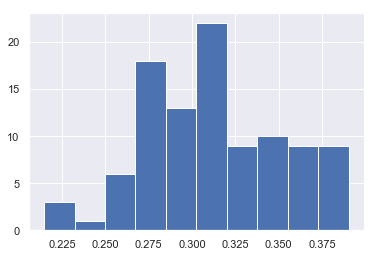

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from_index = 7 # index of x2(t-1). (index:2)+(n_features:5)*(lag:1) = 7
to_index = 2 # index of x2(t). (index:2)+(n_features:5)*(lag:0) = 2
plt.hist(result.total_effects_[:, to_index, from_index])